In [ ]:
! pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 4.9 MB/s 
     |████████████████████████████████| 9.8 MB 25.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


# Questão 12.4
An autoregressive AR(4) complex process is given by \\
$r(k) = 1.8r(k-1) - 2.0r(k-2) + 1.2r(k-3) - 0.4r(k-4) + n(k), $
where the input $n(k)$ is colored noise. Predict the output using the RBF-AR model.

# Gerando função base:

In [ ]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

np.random.seed(12345)
arparams = np.array([1.8, -2, 1.2, -0.4])
maparams = np.array([])
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag
arma_process = sm.tsa.ArmaProcess(ar, ma)
r = arma_process.generate_sample(201)


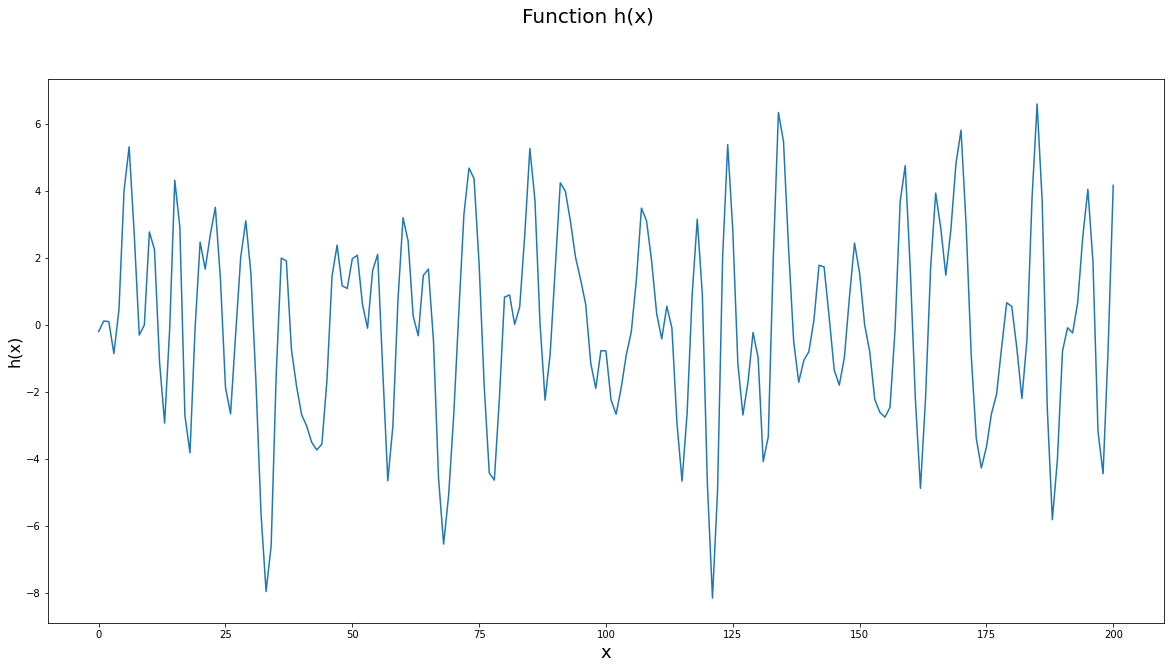

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 10))

plt.plot(r)

fig.suptitle('Function h(x)', fontsize=20)
plt.xlabel('x', fontsize=18)
plt.ylabel('h(x)', fontsize=16)

#plt.ylim(50,15000)
plt.show()

In [ ]:
r_train =r[0:160]
r_test =r[160:-1]

# Metodologia

Neste exercício, utilizamos o modelo ARIMA como baseline para avaliar a performance do modelo proposto. 

Para avaliar ambos os modelos com as mesmas condições, ambos foram avaliados no mesmo conjunto de treino e teste, que consistem em 80% e 20% da série temporal "r". 

Para gerar as previsões da série, foi utilizada a metodologia de janela deslizante, onde os modelos observam N entradas anteriores e geram a previsão para apenas uma saída no futuro. Conforme a janela deslizante percorre o conjunto de teste, o modelo tem acesso à novos valores da série para gerar os valores futuros. 

A imagem a seguir ilustra o funcionamento do modelo com uma janela de tamanho 4.

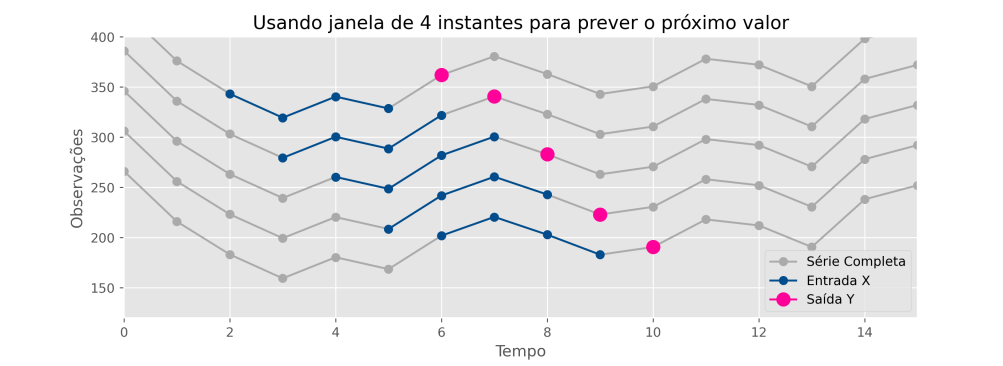

[Fonte da imagem ]((https://dataml.com.br/series-temporais-como-aprendizado-supervisionado/))

Observação: Neste exercício não foi realizada uma análise de autocorrelação e autocorrelação parcial da série principal nem da série gerada pelo modelo ARIMA. O objetivo foi realizar uma simples comparação visual das séries geradas pelos modelos versus a série de teste utilizada.

# Modelo ARIMA (Baseline)

In [ ]:
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha =0.05)
adf_test.should_diff(r)

(0.01, False)

In [ ]:
from pmdarima.arima.auto import auto_arima
#arima_model = auto_arima(r_train,start_p=0,d=1,start_q=0,max_p=5,max_q=5,seasonal=False)

In [ ]:
def walk_forward_validation_ARIMA(train,test):
	predictions = list()
	#train, test = train_test_split(data, n_test)
	stepwise_model_ad =  auto_arima(train, seasonal=True, m=12) # ,m=12
	order = stepwise_model_ad.get_params()['order']
	seasonal_order =  stepwise_model_ad.get_params()['seasonal_order']
	#forecasts_ad  = stepwise_model_ad.forecast(1)
	#print(data)
	#model,_ = model_fit(train, cfg)resid()
	train_resid = stepwise_model_ad.resid()
	#plot_acf(train_resid)
	#plot_pacf(train_resid)
	history = [x for x in train]
	
	for i in test:
		#pdb.set_trace()
		model = sm.tsa.statespace.SARIMAX(history,order=order,seasonal_order=seasonal_order,enforce_stationarity=False,enforce_invertibility=False)
		#yhat = stepwise_model_ad.predict(1)[0] #model_predict(model, history, cfg)
		model_fit = model.fit()
		output = model_fit.forecast()
		yhat = output[0]
		predictions.append(yhat)
		history.append(i)
	#rmse,mae = get_errors(test, predictions)
	return predictions

In [ ]:
#arima_pred = arima_model.predict(n_periods = 40)
arima_pred  = walk_forward_validation_ARIMA(r_train,r_test)


### Série Prevista pelo Modelo ARIMA

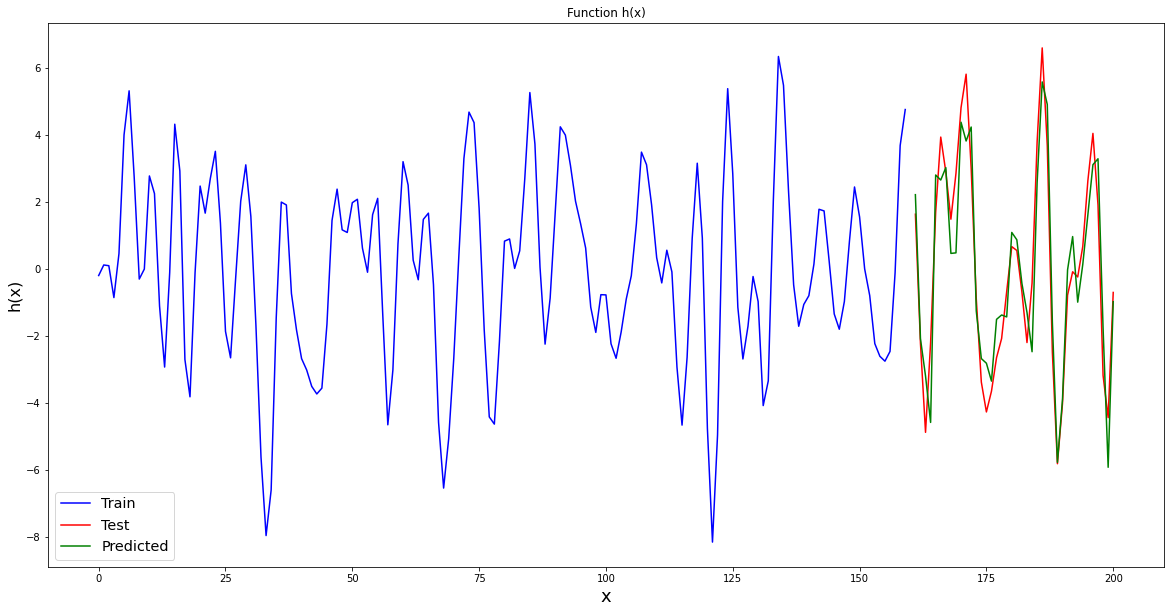

In [ ]:
from matplotlib import pyplot as plt

r_train_scope = range(0,160)
r_test_scope = range(161,201)
arima_pred_scope = range(161,201)

fig, ax = plt.subplots(figsize=(20, 10))
#fig = plt.figure(figsize=(20, 10))
ax.plot(r_train_scope, r_train, label='Train', color='blue')
ax.plot(r_test_scope,r_test, label='Test', color = 'red')
ax.plot(arima_pred_scope,arima_pred, label='Predicted', color = 'green')
legend = ax.legend( fontsize='x-large')

plt.xlabel('x', fontsize=18)
plt.ylabel('h(x)', fontsize=16)
plt.title('Function h(x)')
plt.show()

Podemos observar que o Modelo ARIMA conseguiu uma boa aproximação da série de teste da função r. Na literatura, geralmente os modelos clássicos de previsão de séries temporais como o ARIMA conseguem performar melhor que modelos baseados em aprendizagem de máquina, quando as séries apresentam apenas autocorrelações lineares.

# Modelo RNN + RBF (modelo proposto)

## 1) Conversão em problema supervisonado:
 Primeiro precisamos converter esse problema em um problema supervisonado, onde a rede neural recebe N momentos anteriores da série para realizar a previsão do momento futuro. A função series_to_supervised cria uma base para realizar a aprendizagem supervisonada.

Neste exercício, definimos que o modelo receberá os 5 passos anteriores para prever o valor futuro da série.

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

## 2) Divisão em treino e teste

Nessa parte, a base gerada é dividida entre treino e teste.

In [ ]:
look_back = 5
data_train = series_to_supervised(r_train.tolist(), look_back)
x_train = data_train.values[:, 0:look_back-1]
y_train = data_train.values[:, look_back]

In [ ]:
look_back = 5
data_test = series_to_supervised(r_test.tolist(), look_back)
x_test = data_test.values[:, 0:look_back-1]
y_test = data_test.values[:, look_back]

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
y_train = y_train.reshape(y_train.shape[0],1)
y_test = y_test.reshape(y_test.shape[0],1)


## 3) Definição da arquitetura da rede

Nessa etapa, a arquitetura da rede é definida. A arquitetura utilizada consiste em uma camada de entrada com N nodos (N = pontos anteriores da série), uma camada recorrente, seguida de uma camada RBF e, por fim, uma camada de saída com um nodo, que retorna o valor previsto da série para os N passos anteriores.

In [ ]:
from keras.layers import Layer
from keras import backend as K

class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [ ]:
import pandas as pd
import numpy as np

X = x_train #np.load('../input/k49-train-imgs.npz')['arr_0']
y = y_train#np.load('../input/k49-train-labels.npz')['arr_0']
#y = (y <= 25).astype(int)



In [ ]:
from keras.layers import Dense, Flatten, LSTM, SimpleRNN, LeakyReLU
from keras.models import Sequential
from keras.losses import binary_crossentropy

def model_instance(RBF_kernels,RNN_nodes):
  LReLU = LeakyReLU(alpha=0.5)
  model = Sequential()
  #model.add(Flatten(input_shape=(28, 28)))

  model.add( SimpleRNN(RNN_nodes, activation=LReLU) )
  model.add( RBFLayer(RBF_kernels, 0.1))
  model.add( Dense(1, activation=LReLU))

  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse'])
  return model

## 4) Avaliação da curva de perda

Nesta etapa, avaliamos o gráfico de *loss* do conjunto de treino e teste para a quantidade de épocas analisadas. 

Nesse gráfico, fica evidente o overfitting após 200 iterações.

In [ ]:
model = model_instance(50,20)

In [ ]:
history = model.fit(X, y, batch_size=1024, epochs=1000, validation_data=[x_test,y_test], verbose=0 )

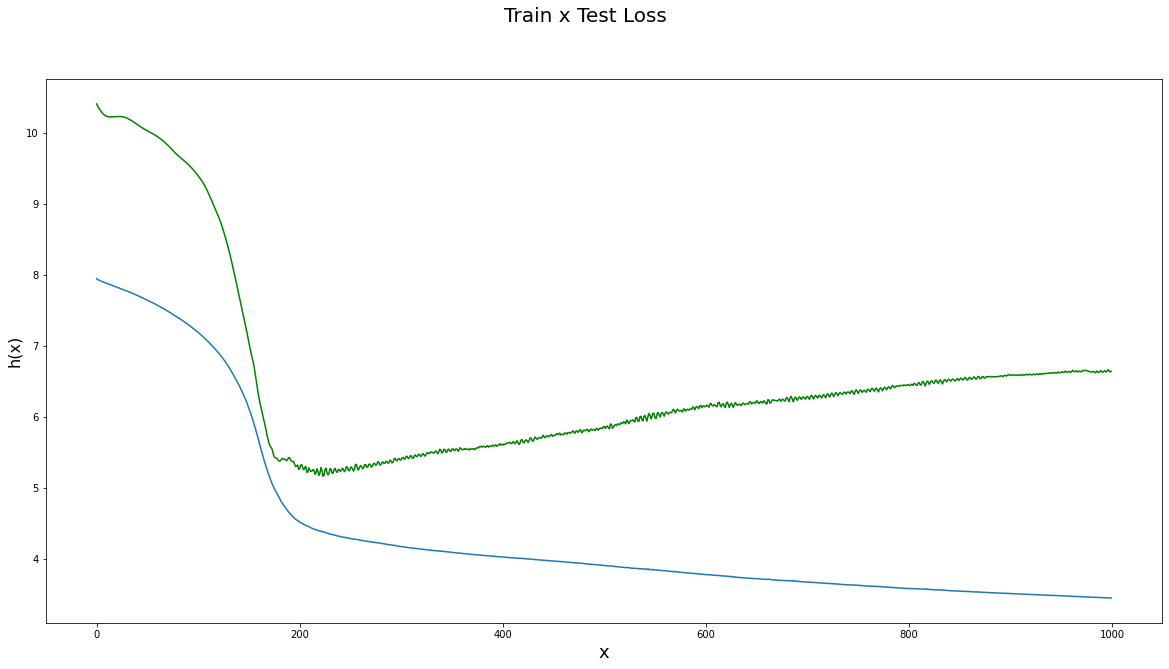

In [ ]:
fig = plt.figure(figsize=(20, 10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], color='green')
fig.suptitle('Train x Test Loss', fontsize=20)
plt.xlabel('x', fontsize=18)
plt.ylabel('h(x)', fontsize=16)

#plt.ylim(50,15000)
plt.show()

## 5) Execução da previsão

Por fim, a rede neural é treinada na série de treino e gera um conjunto de teste observado no último gráfico.

In [ ]:
def walk_forward_validation_NN(x_train, y_train, x_test, y_test ):
  predictions = []
  model = model_instance(50,20)
  model.fit(x_train, y_train, batch_size=1024, epochs=230, verbose=0)
  history = x_train#np.array([x for x in x_train])
  #history = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
  #pdb.set_trace()
  for i in x_test:
    aux = model.predict(history, verbose=0)
    #print(aux)
    yhat=aux[-1]
    predictions.append(yhat)
    #history.append(i)
    history = np.append(history, np.reshape(i, (1, i.shape[0], i.shape[1])), axis=0)
  #rmse,mae = get_errors(test, predictions)
  return [c[0] for c in predictions]

In [ ]:
#j_pred = model2.predict(x_test, verbose=0)
j_pred = walk_forward_validation_NN(x_train, y_train, x_test, y_test)

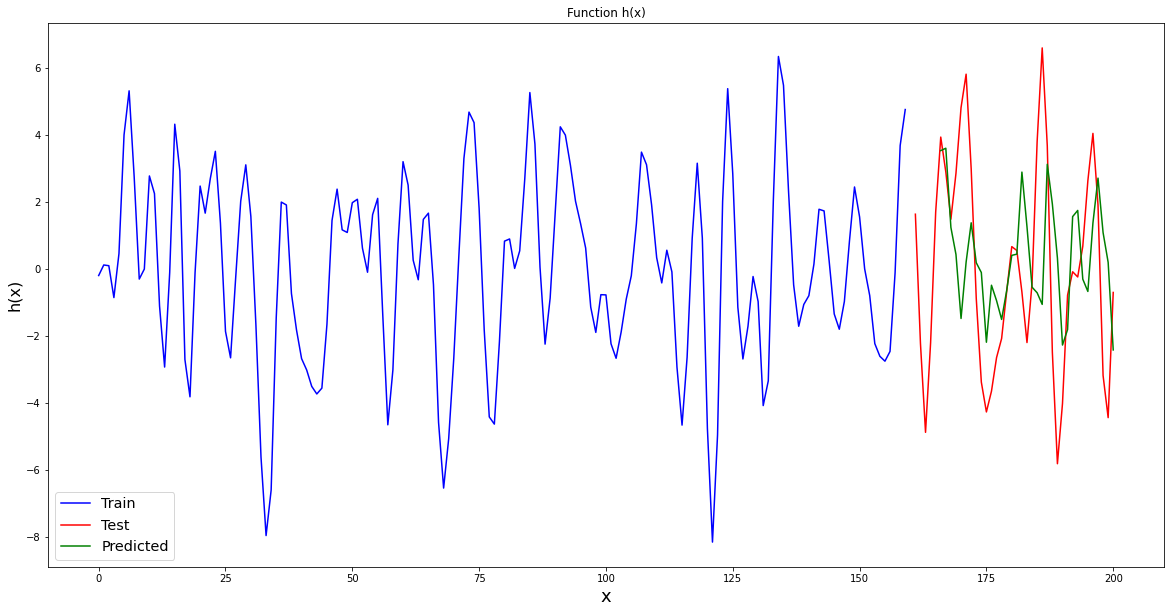

In [ ]:
from matplotlib import pyplot as plt

r_train_scope = range(0,160)
r_test_scope = range(161,201)
j_pred_scope = range(166,201)

fig, ax = plt.subplots(figsize=(20, 10))
#fig = plt.figure(figsize=(20, 10))
ax.plot(r_train_scope, r_train, label='Train', color='blue')
ax.plot(r_test_scope,r_test, label='Test', color = 'red')
ax.plot(j_pred_scope,j_pred, label='Predicted', color = 'green')
legend = ax.legend( fontsize='x-large')

plt.xlabel('x', fontsize=18)
plt.ylabel('h(x)', fontsize=16)
plt.title('Function h(x)')
plt.show()

Neste gráfico percebemos que a saída da rede neural proposta não performou melhor do que o modelo ARIMA, utilizado como baseline para comparação.